In [1]:
from IORlib.utils import ceildiv
import matplotlib.pyplot as pl
from numpy import s_ as np_s_
%matplotlib widget

def figures(*keywords, ncols=1):
    # Create figure and axes
    nplots = len(keywords)
    nrows = ceildiv(nplots, ncols)
    fig = pl.figure(figsize=(8*ncols, 4*nrows))
    axes = {key:fig.add_subplot(nrows, ncols, i+1) for i,key in enumerate(keywords)}
    fig.subplots_adjust(hspace=0.5, wspace=0.25)
    return axes

In [2]:
def lim(is_true):
    return np_s_[1:-1] if is_true else np_s_[:]

def dQ(phase, cell):
    x,y,z = [i>2 for i in cell.flroili.shape[-3:]]
    #print(x,y,z)
    #print(cell.flroili.shape[-3:])
    I,J,K = [f'flr{phase}{d}' for d in ('i','j','k')]
    # Take difference between neighbouring input and output cells
    # For positive direction, cell 1 has cell 0 as input and cell 2 as output 
    if x:
        dQx = getattr(cell,I)[:, :-2, :  , :  ] - getattr(cell,I)[:, 2:,  :,  :]
    if y:
        dQy = getattr(cell,J)[:, :  , :-2, :  ] - getattr(cell,J)[:,  :, 2:,  :] 
    if z:
        dQz = getattr(cell,K)[:, :  , :  , :-2] - getattr(cell,K)[:,  :,  :, 2:]
    #return dQx
    # return (dQx[:,  :  , 1:-1, 1:-1] + 
    #         dQy[:, 1:-1,  :  , 1:-1] + 
    #         dQz[:, 1:-1, 1:-1,  :  ])
    
    return 0.5*( (dQx[:, :     , lim(y), lim(z)] if x else 0) + 
                 (dQy[:, lim(x), :     , lim(z)] if y else 0) + 
                 (dQz[:, lim(x), lim(y), :     ] if z else 0) )

def dS(cell):
    D = {}
    soil = 1 - cell.swat - cell.sgas
    D['dSo'] = soil[1:,...] - soil[:-1,...]
    D['dSw'] = cell.swat[1:,...] - cell.swat[:-1,...]
    D['dSg'] = cell.sgas[1:,...] - cell.sgas[:-1,...]
    return D

def dS_from_dQ(cell):
    dt = cell.days[1:] - cell.days[:-1]
    D = {}
    x,y,z = [i>2 for i in cell.rporv.shape[-3:]]
    for phase in ('oil', 'wat', 'gas'):
        dQph = dQ(phase, cell)
        #print(f'dQ{phase}:', dQph.shape)
        # Units:                   [days]        *    [RB/day]  /       [RB]
        D['dV'+phase[0]] = (dt[:,None,None,None] * dQph[1:,...])/cell.rporv[1:, lim(x), lim(y), lim(z)] 
        #D['dV'+phase[0]] = (dt[:,None,None,None] * dQph[1:,...])/cell.rporv[1:,1:-1,...] 
        #D['dV'+phase[0]] = (dt[:,None,None,None] * dQph[1:,...])/cell.rporv[1:,1:-1,1:-1,1:-1] 
    return D
   

In [3]:
from collections import namedtuple
from itertools import islice
from IORlib.ECL import UNRST_file
from IORlib.utils import take
from pathlib import Path

home = Path.home()
shared = Path('/home/shared/owner')
#root = shared/'CoP_files/input/IORSIM_BASECASE/IORSIM_BASECASE_INPUT'
#root = home/'Downloads/norne_felix_2/SIMPLE_TRACER_INTERSECT'
root = home/'Downloads/18_INTERSECT_CO2/SIMPLE_CO2_IX'
#root = home/'github/IORSim_GUI/cases/L18_FWD/L18_FWD'
#root = shared/'norne/NORNE_INTERSECT'
#root = home/'github/IORSim_GUI/IXF_Examples/Low_Salinity/Low_Salinity'
unrst = UNRST_file(root)
#unrst.count_sections()
cell = next(unrst.cellarray('SWAT', 'SGAS', 'RPORV', 'FLR???[IJK]+'))
#cell.swat.shape


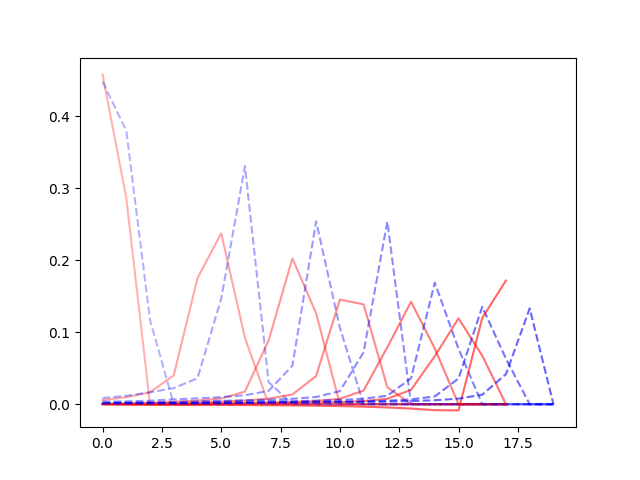

In [21]:
D = dict(**dS_from_dQ(cell), **dS(cell))
pl.close('all')
pl.figure()
#D['dVg'][0].squeeze()
for i,t in enumerate(range(0,20,3)):
    pl.plot(D['dVg'][t].squeeze(), 'r-', alpha=0.3+0.05*i)
    pl.plot(D['dSg'][t].squeeze(), 'b--', alpha=0.3+0.05*i)
#pl.title('dVg')
#t = 5
#pl.imshow(D['dVg'][t,:,:,:]), pl.colorbar()
#pl.figure()
#pl.title('dSg')
#pl.imshow(D['dSg'][t,1:-1,:,:]), pl.colorbar()
#pl.imshow(D['dSo'][t,1:-1,1:-1,:]), pl.colorbar()
#pl.show()


In [ ]:
#total = D['dVo'] + D['dVw'] + D['dVg']
#total.max(), total.min()
#D['dVw'].max(), D['dVw'].min()
tot = D['dSo'] + D['dSw'] + D['dSg']
tot.shape


In [ ]:
#soil.shape
#pl.figure()
#pl.imshow(soil[:,:,14,0]), pl.colorbar()
for var,fig in figures('dVo', 'dSo').items():
    fig.set_title
    #print(D[var].shape)
    im = fig.imshow(D[var][1,:,:,2])
    pl.colorbar(im)


In [ ]:
import numpy as np
A = np.arange(100).reshape(4,25)
x = True
la = np.s_[1:-1]
lb = np.s_[:]
A[x and la or lb,:]